# The Graph of Sententially Co-Occurrent 2-Grams in Text Data

## Moses Boudourides

In [1]:
import pandas as pd
import numpy as np
import urllib2 
import re, string, math, random, operator
import nltk
nltk.download('punkt')
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer #, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import itertools as it
import community
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mosesboudourides/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load data

In [2]:
url = "https://www.gutenberg.org/files/16/16-0.txt" # peter pan from the gutenberg project
request = urllib2.Request(url)
response = urllib2.urlopen(request)
peter_pan = response.read().decode('utf-8')
titlename="Peter Pan"

### Trim preface and epilogue and split in Chapters

In [3]:
peter_pan = peter_pan[0:263923]
print(len(peter_pan))

263923


In [4]:
chapters = peter_pan[0:1466]
chapters = chapters[917:1466]
print(len(chapters))

549


In [5]:
chapter_ls = [x.strip() for x in chapters.split('\r\n') if x.strip()]
chapter_ls[7] = "Chapter 8 THE MERMAIDS' LAGOON"
print(len(chapter_ls))

17


In [6]:
for c in chapter_ls:
    print(c)

Chapter 1 PETER BREAKS THROUGH
Chapter 2 THE SHADOW
Chapter 3 COME AWAY, COME AWAY!
Chapter 4 THE FLIGHT
Chapter 5 THE ISLAND COME TRUE
Chapter 6 THE LITTLE HOUSE
Chapter 7 THE HOME UNDER THE GROUND
Chapter 8 THE MERMAIDS' LAGOON
Chapter 9 THE NEVER BIRD
Chapter 10 THE HAPPY HOME
Chapter 11 WENDY'S STORY
Chapter 12 THE CHILDREN ARE CARRIED OFF
Chapter 13 DO YOU BELIEVE IN FAIRIES?
Chapter 14 THE PIRATE SHIP
Chapter 15 “HOOK OR ME THIS TIME”
Chapter 16 THE RETURN HOME
Chapter 17 WHEN WENDY GREW UP


In [7]:
peter_pan = peter_pan[0:263923]  # trim epilogue
peter_pan = peter_pan[1476:len(peter_pan)] # trim prefave
peter_pan[:1000]

u"Chapter 1 PETER BREAKS THROUGH\r\n\r\nAll children, except one, grow up. They soon know that they will grow\r\nup, and the way Wendy knew was this. One day when she was two years old\r\nshe was playing in a garden, and she plucked another flower and ran with\r\nit to her mother. I suppose she must have looked rather delightful, for\r\nMrs. Darling put her hand to her heart and cried, \u201cOh, why can't you\r\nremain like this for ever!\u201d This was all that passed between them on\r\nthe subject, but henceforth Wendy knew that she must grow up. You always\r\nknow after you are two. Two is the beginning of the end.\r\n\r\nOf course they lived at 14 [their house number on their street], and\r\nuntil Wendy came her mother was the chief one. She was a lovely lady,\r\nwith a romantic mind and such a sweet mocking mouth. Her romantic\r\nmind was like the tiny boxes, one within the other, that come from the\r\npuzzling East, however many you discover there is always one more; and\r\nher s

In [8]:
peter_pan_ls = peter_pan.split('\r\n\r\n')
peter_pan_df = pd.DataFrame(peter_pan_ls, columns = ['text'])
peter_pan_df.text = peter_pan_df.text.str.strip() # get rid of whitespace
print(peter_pan_df.shape)
peter_pan_df.head()

(1686, 1)


,text
0,Chapter 1 PETER BREAKS THROUGH
1,"All children, except one, grow up. They soon k..."
2,Of course they lived at 14 [their house number...
3,The way Mr. Darling won her was this: the many...
4,Mr. Darling used to boast to Wendy that her mo...


In [9]:
# peter_pan_df['chapter_index'] = peter_pan_df.text.apply(lambda x: chapter_ls.index(x)+1 if x in chapter_ls else 0)
peter_pan_df['chapter_index'] = peter_pan_df.text.apply(lambda x: 1 if x in chapter_ls else 0)
peter_pan_df['chapter'] = np.cumsum(peter_pan_df.chapter_index)
print(peter_pan_df.shape)
peter_pan_df.loc[peter_pan_df.chapter_index != 0,:]

(1686, 3)


,text,chapter_index,chapter
0,Chapter 1 PETER BREAKS THROUGH,1,1
54,Chapter 2 THE SHADOW,1,2
160,"Chapter 3 COME AWAY, COME AWAY!",1,3
353,Chapter 4 THE FLIGHT,1,4
485,Chapter 5 THE ISLAND COME TRUE,1,5
574,Chapter 6 THE LITTLE HOUSE,1,6
711,Chapter 7 THE HOME UNDER THE GROUND,1,7
734,Chapter 8 THE MERMAIDS' LAGOON,1,8
899,Chapter 9 THE NEVER BIRD,1,9
925,Chapter 10 THE HAPPY HOME,1,10


In [10]:
peter_pan_filtered = peter_pan_df.loc[peter_pan_df.chapter_index == 0,:]
# peter_pan_filtered.text = peter_pan_filtered.text.apply(lambda x: re.sub(r'[^\w\s]','',x)) # filter out punctuation
peter_pan_filtered.text = peter_pan_filtered.text.apply(lambda x: re.sub('\r|\n',' ',x)) # filter out indentation spaces
peter_pan_filtered.text = peter_pan_filtered.text.apply(lambda x: x.lower()) # strip whitespace
peter_pan_filtered = peter_pan_filtered[['text','chapter']]
print (peter_pan_filtered.shape)
peter_pan_filtered.head()

(1669, 2)


,text,chapter
1,"all children, except one, grow up. they soon k...",1
2,of course they lived at 14 [their house number...,1
3,the way mr. darling won her was this: the many...,1
4,mr. darling used to boast to wendy that her mo...,1
5,"mrs. darling was married in white, and at firs...",1


In [11]:
peter_pan_chapter_str = peter_pan_filtered.groupby(['chapter'])['text'].apply(' '.join).reset_index()
peter_pan_chapter_str.text = peter_pan_chapter_str.text.str.strip() # get rid of whitespace
peter_pan_chapter_str['str_length'] = peter_pan_chapter_str.text.apply(len)
print (peter_pan_chapter_str.shape)
df=peter_pan_chapter_str
# df

(17, 3)


In [12]:
text=[]
for i in range(len(df)):
    text.append(df.iloc[i]["text"])
print(len(text))
# text[3]

17


In [13]:
# 2-grams vectorization of text
vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range=(2,2))  #(1,2)
X = vectorizer.fit_transform(text)
words = vectorizer.get_feature_names()
# print("words", len(words),words) 

In [14]:
n_clusters=10 #len(text)
number_of_terms=300
number_of_seeds_to_try=10
max_iter = 500
number_of_process=2 # seads are distributed
model = KMeans(n_clusters=n_clusters, max_iter=max_iter, n_init=number_of_seeds_to_try, n_jobs=number_of_process).fit(X)

labels = model.labels_
# indices of preferible words in each cluster
ordered_words = model.cluster_centers_.argsort()[:, ::-1]

# # print("centers:", model.cluster_centers_)
# # print("labels", labels)
# # print("intertia:", model.inertia_)

centers=model.cluster_centers_

text_per_cluster = np.zeros(n_clusters)
for i_cluster in range(n_clusters):
    for label in labels:
        if label==i_cluster:
            text_per_cluster[i_cluster] +=1 

top_2grams=[]
# print("Top words per cluster:")
for i_cluster in range(n_clusters):
#     print("Cluster:", i_cluster, "text:", int(text_per_cluster[i_cluster])),
    for term in ordered_words[i_cluster, :number_of_terms]: 
#         print("\t"+words[term])
        if term not in top_2grams:
            top_2grams.append(words[term])

top_2grams=[t for t in top_2grams if len(t)>2]            
top_2grams=sorted(set(top_2grams))
top_2grams=[str(w) for w in top_2grams]
print("top 2grams",len(top_2grams))
top_2grams[:10]

('top 2grams', 2915)


['absolutely finished',
 'adventure hours',
 'adventures tell',
 'ago mark',
 'ah old',
 'answer rang',
 'answered braves',
 'answered cheer',
 'answered don',
 'appealing outstretched']

In [15]:
occurdic={}
for np in top_2grams:
    s=0
    for t in text:
        s+=t.count(np)
    occurdic[np]=s

df = pd.DataFrame(columns=["%s 2-gram" %titlename, "Frequency"])
u=1
for l,v in occurdic.items(): 
    df.loc[u]=[l,v]
    u+=1

print "The total number of 2-grams in %s is %i." %(titlename,len(df))#len(npA))
df.sort_values(["Frequency"], ascending=[0])

cut = 1
df = df[df['Frequency']>cut].sort_values(["Frequency"], ascending=[0])
print "The total number of 2-grams in %s with frequencies > %i is %i." %(titlename,cut,len(df))#len(npA))
df.sort_values(["Frequency"], ascending=[0]).head()

The total number of 2-grams in Peter Pan is 2915.
The total number of 2-grams in Peter Pan with frequencies > 1 is 174.


,Peter Pan 2-gram,Frequency
1078,tinker bell,29
826,said peter,20
2711,wendy said,19
376,peter pan,18
2442,oh dear,15


## Sentences

In [16]:
textSentences=[]
for t in text:
    blob = TextBlob(t)
    ts = blob.sentences
    textSentences.append(ts)
textSentences = [item for sublist in textSentences for item in sublist]
print(len(textSentences))
textSentences[:10]

2316


[Sentence("all children, except one, grow up."),
 Sentence("they soon know that they will grow  up, and the way wendy knew was this."),
 Sentence("one day when she was two years old  she was playing in a garden, and she plucked another flower and ran with  it to her mother."),
 Sentence("i suppose she must have looked rather delightful, for  mrs. darling put her hand to her heart and cried, “oh, why can't you  remain like this for ever!” this was all that passed between them on  the subject, but henceforth wendy knew that she must grow up."),
 Sentence("you always  know after you are two."),
 Sentence("two is the beginning of the end."),
 Sentence("of course they lived at 14 [their house number on their street], and  until wendy came her mother was the chief one."),
 Sentence("she was a lovely lady,  with a romantic mind and such a sweet mocking mouth."),
 Sentence("her romantic  mind was like the tiny boxes, one within the other, that come from the  puzzling east, however many you dis

In [17]:
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in top_2grams:
        if term in v: #.split(): #dd['stripped'].split():
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl #ww1
# sendic

In [18]:
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in it.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        medges.append((jj[0],jj[1],"Sentence_"+str(k),ss/float(s)))
print len(medges) #,len(set(medges))  
S=len(medges)
# medges

432


In [19]:
medgesd=[]
for e in medges:
    d={}
    d['Sentence']=e[2]
    d['Average sentiment']=e[3]
    medgesd.append((e[0],e[1],d))
# for e in medgesd:
#     print e

In [20]:
G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
print "Nodes =",len(G.nodes())
print "Multiedges =",len(G.edges())
# for e in G.edges(data=True):
#     print e

Nodes = 378
Multiedges = 432


In [21]:
df = nx.to_pandas_edgelist(G) 
# df
df.rename(columns={'source':'First 2-gram term','target':'Second 2-gram term'}, inplace=True)
df=df[['First 2-gram term','Second 2-gram term','Average sentiment','Sentence']]
df.head()

,First 2-gram term,Second 2-gram term,Average sentiment,Sentence
0,wendy told,frightfully anxious,0.0375,Sentence_1409
1,arms fall,outstretched arms,0.3750,Sentence_1559
2,green light,light squinting,0.0800,Sentence_1715
3,green light,like ground,0.0800,Sentence_1715
4,green light,mangled feathers,0.0800,Sentence_1715


In [22]:
weight={(x,y):v['Average sentiment'] for x,y,v in G.edges(data=True)}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)
N=len(Gw.nodes())

In [23]:
print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print "The density of Gw is %.3f" %nx.density(Gw)
if nx.is_connected(Gw)==True:
    print "Gw is a connected graph"
else:
    print "Gw is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components"    
giant = max(nx.connected_component_subgraphs(Gw), key=len)
Gwlcc=Gw.subgraph(giant)
print "The largest connected component of Gw is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges()))
print "The density of the largest connected component of Gw is %.3f" %nx.density(Gwlcc)

lccmedges=[]
for e in medges:
    if e[0] in giant and e[1] in giant:
        lccmedges.append((e[0],e[1]))
NN=len(Gwlcc.nodes())
SS=len(lccmedges)

Graph Gw is a weighted graph with 378 nodes and 420 edges
The density of Gw is 0.006
Gw is a disconnected graph and it has 92 connected components
The largest connected component of Gw is a weighted graph with 135 nodes and 206 edges
The density of the largest connected component of Gw is 0.023


In [24]:
# for e in Gw.edges(data=True):
#     print e

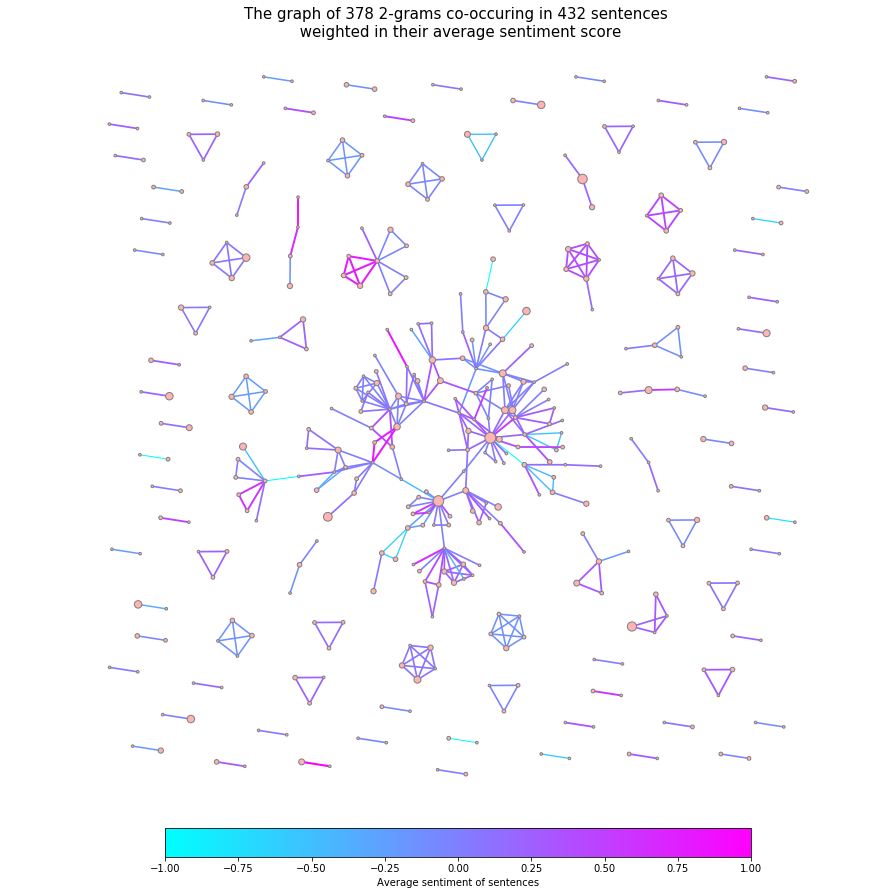

In [25]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
# elabels = nx.get_edge_attributes(Gw,'weight')
edge_width1=[10*(0.1+w) for w in edge_width] 
# print edge_width

figsize=(15,17)

cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list

pos=graphviz_layout(Gw) 
node_color="#ffb3b3"
node_border_color="grey"
# edge_color="#668cff"

d = Gw.degree()
node_size=[7*v[1] for v in list(nx.degree(G))]

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos,node_color=node_color,node_size=node_size)
nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width,a=1)
nx.draw_networkx_edges(Gw, pos,width=width_list,edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,alpha=1)
labels_no={}
for n in G.nodes():
    labels_no[n]=''
nx.draw_networkx_labels(G, pos,labels=labels_no)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
# yoffset = {}
# y_off = -15   # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(Gw, yoffset,font_size=8);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of %i 2-grams co-occuring in %i sentences \n weighted in their average sentiment score" %(N,S) 
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.05) 

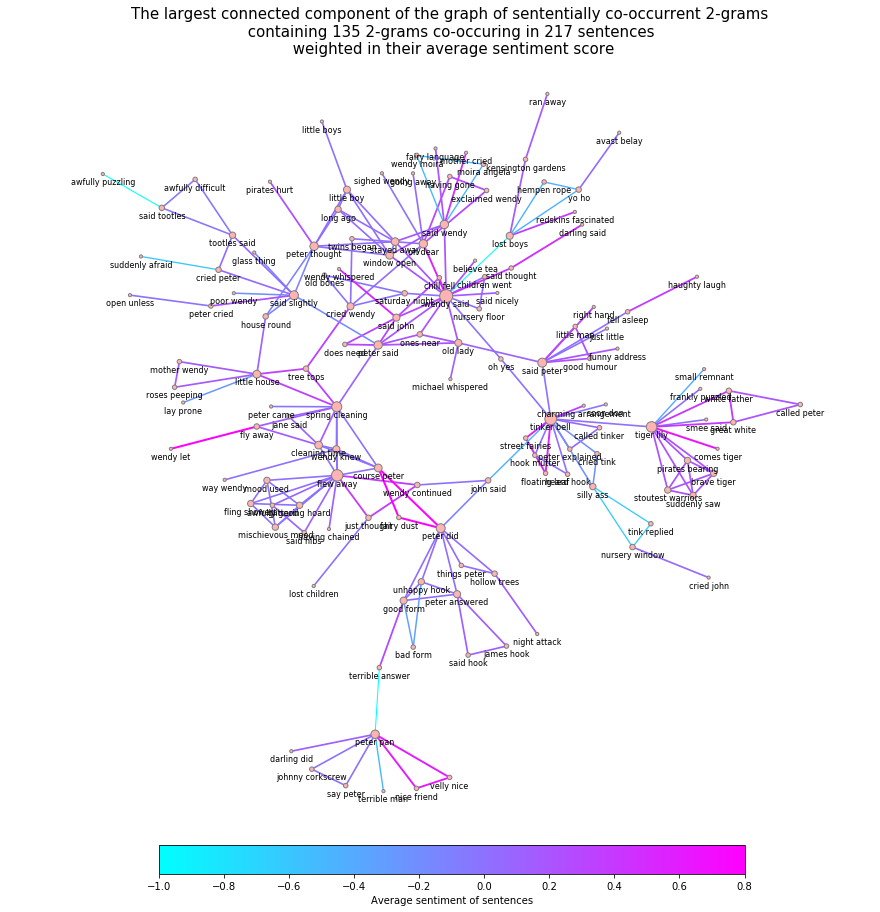

In [26]:
figsize=(15,17)

cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gwlcc.edges(data=True) ]

edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list

pos=graphviz_layout(Gwlcc) 
node_color="#ffb3b3"
node_border_color="grey"
# edge_color="#668cff"

d = Gwlcc.degree()
node_size=[10*v[1] for v in list(nx.degree(Gwlcc))]

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gwlcc, pos,node_color=node_color,node_size=node_size)
nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width,a=1)
nx.draw_networkx_edges(Gwlcc, pos,width=width_list,edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,alpha=1)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -10   # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gwlcc, yoffset,font_size=8);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The largest connected component of the graph of sententially co-occurrent 2-grams \n containing %i 2-grams co-occuring in %i sentences \n weighted in their average sentiment score" %(NN,SS) 
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.05) 

### Centralities of 2-Grams in the Largest Connected Component of the Graph of Sententially Co-Occurring 2-Grams

In [27]:
def create_centralities_list(G,maxiter=2000,pphi=5,centList=[]):
    if len(centList)==0:
        centList=['degree','closeness','betweenness','eigenvector','Katz'] #,'PageRank','HITS','load','communicability','current flow']
    cenLen=len(centList)
    valus={}
    for uu,centr in enumerate(centList):
        if centr=='degree':
            if isinstance(G,nx.DiGraph):
                cent=nx.in_degree_centrality(G)
                sstt='In Degree Centralities '
                valus['in_degree']=cent
                cent=nx.out_degree_centrality(G)
                sstt+= 'and Out Degree Centralities'
                valus['out_degree']=cent
            else:
                cent=nx.degree_centrality(G)
                sstt='Degree Centralities'
                ssttt='degree centrality'
                valus[centr]=cent
        elif centr=='closeness':
            cent=nx.closeness_centrality(G)
            sstt='Closeness Centralities'
            ssttt='closeness centrality'
            valus[centr]=cent
        elif centr =='load':
            cent=nx.load_centrality(G)
            sstt='Load Centraities'
            valus[centr]=cent
        elif centr == 'communicability':
            if not isinstance(G, nx.DiGraph):
                cent=nx.communicability_betweenness_centrality(G)
                sstt='Communicability Centralities'
                valus[centr]=cent
        elif centr=='betweenness':
            cent=nx.betweenness_centrality(G)
            sstt='Betweenness Centralities'
            ssttt='betweenness centrality'
            valus[centr]=cent
        elif centr=='current flow':
            if not isinstance(G, nx.DiGraph):
            
                cent=nx.current_flow_closeness_centrality(G)
                sstt='Current Flow Closeness Centrality'
                valus[centr]=cent
        elif centr=='eigenvector':
            try:
                cent=nx.eigenvector_centrality(G,max_iter=maxiter)
                sstt='Eigenvector Centralities'
                ssttt='eigenvector centrality'
                valus[centr]=cent

            except:
                valus[centr]=None

                continue
        elif centr=='Katz':
            phi = (1+math.sqrt(pphi))/2.0 # largest eigenvalue of adj matrix
            cent=nx.katz_centrality_numpy(G,1/phi-0.01)
            cent=nx.katz_centrality_numpy(G,.05)#,1/phi-0.01)
            
            sstt='Katz Centralities'
            ssttt='Katz centrality'
            valus[centr]=cent
#             valus[centr+'_%i' %pphi]=cent

        elif centr=='PageRank':
            try:
                cent=nx.pagerank(G)
                sstt='PageRank'
                ssttt='pagerank'
                valus[centr]=cent

            except:
                valus[centr]=None

                continue
        elif centr=='HITS':
            if isinstance(G,nx.DiGraph):
                dd=nx.hits(G,max_iter=maxiter)
                sstt='HITS hubs '
                valus['HITS_hubs']=dd[0]
                sstt+= 'and HITS authorities'
                valus['HITS_auths']=dd[1]
            else:
                dd=nx.hits(G,max_iter=maxiter)
                cent=nx.degree_centrality(G)
                sstt='HITS'
                ssttt='HITS Centralities'
                valus[centr]=dd[0]
        else:
            continue
#         print '%s done!!!' %sstt
    return valus

dindices=['out_degree','in_degree','closeness','betweenness','eigenvector','HITS_hubs','HITS_auths','Katz','PageRank','load']
indices=['degree','closeness','betweenness','eigenvector','HITS','Katz','PageRank','load','communicability','current flow']
# indices=['degree','closeness','betweenness','eigenvector']

# Without 'communicability' and 'current flow' (undirected case)
dindicesd=['out_degree','in_degree','closeness','betweenness','eigenvector','HITS_hubs','HITS_auths','Katz','PageRank','load']
indicesd=['degree','closeness','betweenness','eigenvector','Katz'] #'HITS',,'PageRank','load'
# indicesd=['degree','closeness','betweenness','eigenvector']

dindicesdr=dindicesd
indicesdr=indicesd

# Plus 'node'
dindicesdrn=["node"]+dindicesd
indicesdrn=['node']+indicesd

def central_df(G,node,central_pd):
    central_pd[node]=central_pd.index.values
    if isinstance(G,nx.DiGraph):
        central_pd=central_pd[[node]+dindicesd]
    else:
        central_pd=central_pd[[node]+indicesd]
    central_pd[node]=central_pd.index.values
    central_pd.reset_index(drop = True, inplace = True)
    # central_pd=central_pd[['node']]
    central_pd.sort_values(node) #.head()
    # central_pd['node']=G.nodes()
    return central_pd

In [28]:
G=Gwlcc
central_pd=pd.DataFrame(create_centralities_list(G))
node="node"
central_df(G,node,central_pd).head(5)

,node,degree,closeness,betweenness,eigenvector,Katz
0,avast belay,0.007463,0.162228,0.0,0.003377,0.074717
1,awfully difficult,0.014925,0.168130,0.0,0.005582,0.079109
2,awfully good,0.014925,0.204893,0.0,0.069969,0.081135
3,awfully puzzling,0.007463,0.144241,0.0,0.001042,0.074702
4,bad form,0.014925,0.171575,0.0,0.008465,0.079674


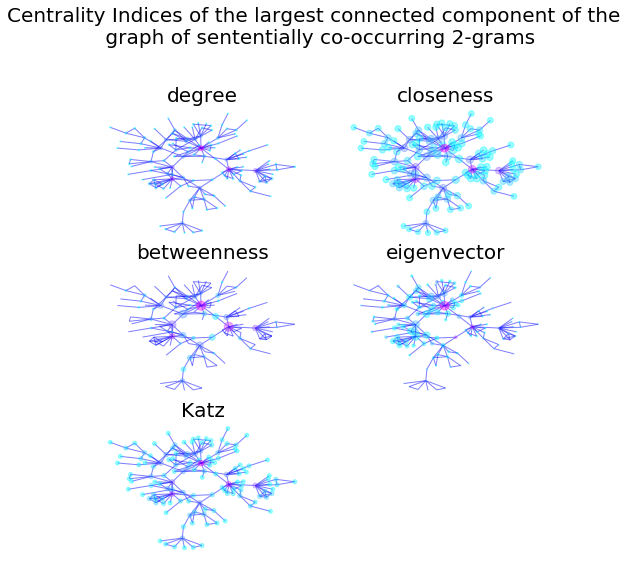

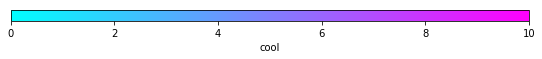

In [29]:
name="the largest connected component of the \n graph of sententially co-occurring 2-grams"
# pos=nx.spring_layout(G,1.)
valus=create_centralities_list(G,maxiter=2000,pphi=5,centList=[])
if isinstance(G,nx.DiGraph):
    cts=['out_degree','in_degree','closeness','betweenness','eigenvector','HITS_hubs','HITS_auths','Katz','PageRank','load']
else:
    cts=['degree','closeness','betweenness','eigenvector','Katz'] #,'load''HITS','PageRank', ,'communicability','current flow']
for cent in valus.values():
    cs={}
    for k,v in cent.items():
        if v not in cs:
            cs[v]=[k]
        else:
            cs[v].append(k)
    nodrank=[]
    uui=0
    for k in sorted(cs,reverse=True):
        for v in cs[k]:
            if uui<len(G): #5:
                nodrank.append(v)
                uui+=1
    nodeclo=[]
    for k,v in cent.items():
        if k in  nodrank :
            nodeclo.append(v)
        else:
            nodeclo.append(0.)

plt.figure(figsize=(8,14))
for i,j in enumerate(cts): 
    plt.subplot(len(cts)+1/2,2,i+1).set_title(j)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=valus[j].keys(),
                               node_size=[200*x for x in valus[j].values()],
                               node_color=nodeclo,
                               cmap=cmap,alpha=0.4) #Reds
    nx.draw_networkx_edges(G,pos=pos,edge_color='b', alpha=0.5)
    plt.title(j,fontsize=20)
    kk=plt.axis('off')
sst="Centrality Indices of %s" %name
plt.suptitle(sst,fontsize=20);

fig=plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.05]) 
# cmap = mpl.cm.PiYG
norm = mpl.colors.Normalize(vmin=0, vmax=10)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
norm=norm,
orientation='horizontal')
cb1.set_label('cool')

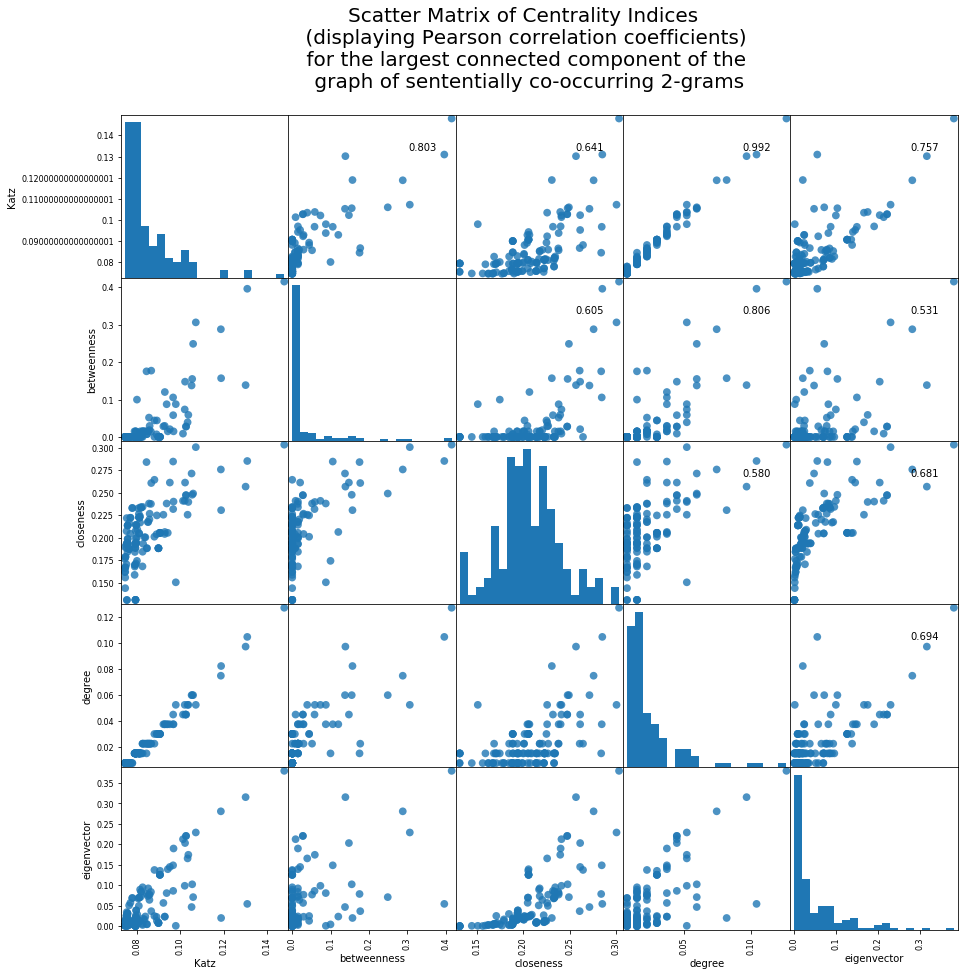

In [30]:
axes = pd.plotting.scatter_matrix(central_pd, figsize=(15, 15), marker='o',hist_kwds={'bins': 20}, s=60, alpha=.8)
corr = central_pd.corr().values 
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
sst="Scatter Matrix of Centrality Indices \n (displaying Pearson correlation coefficients) \n for %s" %name
plt.suptitle(sst,fontsize=20);

### Communities of 2-Grams in the Largest Connected Component of the Graph of Sententially Co-Occurring 2-Grams

In [31]:
mw=min([e[2]['weight'] for e in G.edges(data=True)])
mw
for u,v,d in G.edges(data=True):
    d['weight']+=-mw+0.01
# for e in G.edges(data=True):
#     print e

The graph has 12 communities and modularity coefficient equal to 0.79246810562
Community 0 with 15 nodes: ['peter explained', 'cried john', 'oh yes', 'soon don', 'floating leaf', 'charming arrangement', 'nursery window', 'heard hook', 'called tinker', 'street fairies', 'silly ass', 'cried tink', 'tinker bell', 'tink replied', 'hook mutter']
Community 1 with 15 nodes: ['darling said', 'believe tea', 'nursery floor', 'chill fell', 'old lady', 'michael whispered', 'said john', 'peter said', 'children went', 'ones near', 'does need', 'said thought', 'wendy said', 'said nicely', 'wendy whispered']
Community 2 with 14 nodes: ['little house', 'roses peeping', 'fly away', 'peter came', 'way wendy', 'cleaning time', 'spring cleaning', 'tree tops', 'wendy knew', 'lay prone', 'jane said', 'mother wendy', 'wendy let', 'house round']
Community 3 with 13 nodes: ['said hook', 'peter answered', 'course peter', 'unhappy hook', 'hollow trees', 'good form', 'terrible answer', 'peter did', 'fairy dust', '

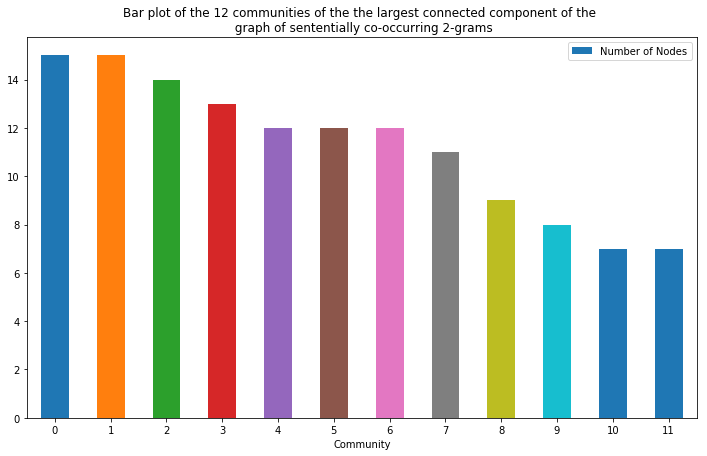

In [32]:
partition = community.best_partition(G)
# print partition

kk=len(set(partition.values()))
modularity=community.modularity(partition, G, weight='weight')
print 'The graph has', kk, 'communities and modularity coefficient equal to', modularity

cml=[]
for j in range(kk):
    cj=[]
    for k,v in partition.items():
        if v==j:
            cj.append(k)
    cml.append(cj)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
louvain_comm_membership={}
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(i[1][0])
    louvain_comm_membership[i[0]]=ts 
    
ddf=pd.DataFrame(commsd.items(), columns=['Community', 'Number of Nodes'])
sst="Bar plot of the %i communities of the %s" %(kk,name)
ddf.plot.bar(x='Community', y='Number of Nodes', figsize=(12,7),rot=0,title=sst);

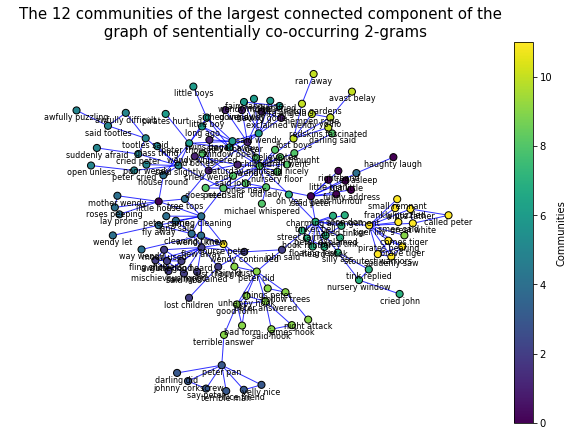

In [33]:
node_color=partition.values()
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(10,7));
node_border_color='k'
nodes = nx.draw_networkx_nodes(G, pos, node_size=50,node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edge_color='b',alpha=0.8)
plt.axis('off');
yoffset = {}
y_off = -20 #0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(G, yoffset,font_size=8);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Communities") #, orientation='horizontal')
sst="The %i communities of %s" %(kk,name)
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 